In [1]:
import jsonlines

In [2]:
%%time
"""
What does the train data look like?
"""
with open("../data/train.jsonl", "r") as file:
    for i, line in enumerate(file):
        if i > 0:
            break
        print(line[:1000])

{"session":0,"events":[{"aid":1517085,"ts":1659304800025,"type":"clicks"},{"aid":1563459,"ts":1659304904511,"type":"clicks"},{"aid":1309446,"ts":1659367439426,"type":"clicks"},{"aid":16246,"ts":1659367719997,"type":"clicks"},{"aid":1781822,"ts":1659367871344,"type":"clicks"},{"aid":1152674,"ts":1659367885796,"type":"clicks"},{"aid":1649869,"ts":1659369893840,"type":"carts"},{"aid":461689,"ts":1659369898050,"type":"carts"},{"aid":305831,"ts":1659370027105,"type":"orders"},{"aid":461689,"ts":1659370027105,"type":"orders"},{"aid":362233,"ts":1659370064916,"type":"clicks"},{"aid":1649869,"ts":1659370067686,"type":"clicks"},{"aid":1649869,"ts":1659371003682,"type":"clicks"},{"aid":984597,"ts":1659371033243,"type":"clicks"},{"aid":1649869,"ts":1659371042297,"type":"clicks"},{"aid":803544,"ts":1659371044075,"type":"clicks"},{"aid":1110941,"ts":1659371104329,"type":"clicks"},{"aid":1190046,"ts":1659371123063,"type":"clicks"},{"aid":1760685,"ts":1659375531385,"type":"clicks"},{"aid":631008,"ts"

In [3]:
%%time
"""
What does the test data look like?
"""
with open("../data/train.jsonl", "r") as file:
    for i, line in enumerate(file):
        if i > 0:
            break
        print(line[:1000])

{"session":0,"events":[{"aid":1517085,"ts":1659304800025,"type":"clicks"},{"aid":1563459,"ts":1659304904511,"type":"clicks"},{"aid":1309446,"ts":1659367439426,"type":"clicks"},{"aid":16246,"ts":1659367719997,"type":"clicks"},{"aid":1781822,"ts":1659367871344,"type":"clicks"},{"aid":1152674,"ts":1659367885796,"type":"clicks"},{"aid":1649869,"ts":1659369893840,"type":"carts"},{"aid":461689,"ts":1659369898050,"type":"carts"},{"aid":305831,"ts":1659370027105,"type":"orders"},{"aid":461689,"ts":1659370027105,"type":"orders"},{"aid":362233,"ts":1659370064916,"type":"clicks"},{"aid":1649869,"ts":1659370067686,"type":"clicks"},{"aid":1649869,"ts":1659371003682,"type":"clicks"},{"aid":984597,"ts":1659371033243,"type":"clicks"},{"aid":1649869,"ts":1659371042297,"type":"clicks"},{"aid":803544,"ts":1659371044075,"type":"clicks"},{"aid":1110941,"ts":1659371104329,"type":"clicks"},{"aid":1190046,"ts":1659371123063,"type":"clicks"},{"aid":1760685,"ts":1659375531385,"type":"clicks"},{"aid":631008,"ts"

In [23]:
% % time
"""
Explore sample of the data
"""
sessions = []
with jsonlines.open("../data/train.jsonl", "r") as reader:
    # Iterate over parsed JSON objects
    for i, obj in enumerate(reader):
        if i > 1_000_000:
            break
        # Combine 'session' and 'events' values for each object
        adj_obj = [x | dict(session=obj['session']) for x in obj['events']]
        sessions.extend(adj_obj)

CPU times: total: 55.8 s
Wall time: 56.1 s


In [24]:
%%time
import pandas as pd

# Load data
subset = sessions
df = (
    # Load JSON Object
    pd.json_normalize(subset)
    # Convert ts to datetime
    .assign(dt=lambda df_: pd.to_datetime(df_['ts'], unit='ms'))
    # Drop ts value
    .drop(['ts'], axis=1)
)
df.head()

CPU times: total: 3min 41s
Wall time: 3min 48s


,aid,type,session,dt
0,1517085,clicks,0,2022-07-31 22:00:00.025
1,1563459,clicks,0,2022-07-31 22:01:44.511
2,1309446,clicks,0,2022-08-01 15:23:59.426
3,16246,clicks,0,2022-08-01 15:28:39.997
4,1781822,clicks,0,2022-08-01 15:31:11.344


Text(0.5, 0, '')

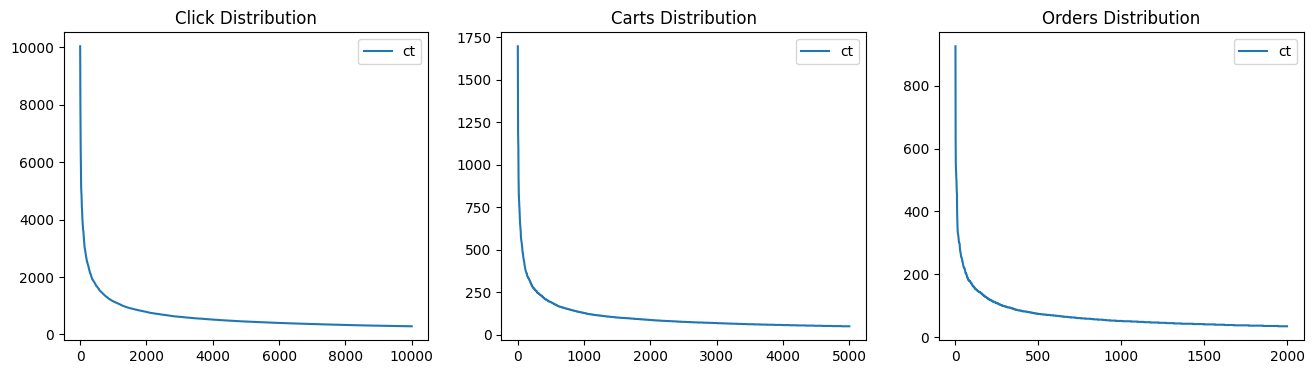

In [25]:
"""
What is the distribution of products clicked?
"""
import matplotlib.pyplot as plt

fig, ax = plt.subplots(ncols=3, figsize=(16,4))
# Clicks
(
    df[df['type'].isin(['clicks'])]
    .groupby('aid')
    .agg(ct=('session', 'nunique'))
    .reset_index().sort_values(['ct'],ascending=False)
    .reset_index(drop=True).reset_index()
    # Filter to elbow in graph
    .loc[:10_000]
    .plot(x='index',y='ct', ax=ax[0],title='Click Distribution')
)

# Carts
(
    df[df['type'].isin(['carts'])]
    .groupby('aid')
    .agg(ct=('session', 'nunique'))
    .reset_index().sort_values(['ct'],ascending=False)
    .reset_index(drop=True).reset_index()
    # Filter to elbow in graph
    .loc[:5_000]
    .plot(x='index',y='ct', ax=ax[1],title='Carts Distribution')
)

# Orders
(
    df[df['type'].isin(['orders'])]
    .groupby('aid')
    .agg(ct=('session', 'nunique'))
    .reset_index().sort_values(['ct'],ascending=False)
    .reset_index(drop=True).reset_index()
    # Filter to elbow in graph
    .loc[:2_000]
    .plot(x='index',y='ct', ax=ax[2],title='Orders Distribution')
)
# Remove xlabel
ax[0].set_xlabel(''); ax[1].set_xlabel(''); ax[2].set_xlabel('')

In [29]:
%%time
from gensim.models import Word2Vec

"""
Naive Word2Vec
"""
# Product Vectors
product_sentences = (
    df.groupby("session")["aid"]
    .apply(list)
    .reset_index()["aid"]
)

# W2V
model = Word2Vec(sentences=product_sentences, min_count=250, vector_size=4, seed=42, workers=-1)

CPU times: total: 59.3 s
Wall time: 59.5 s


Starting reduce...
...completed reduce
CPU times: total: 19min 16s
Wall time: 1min 19s


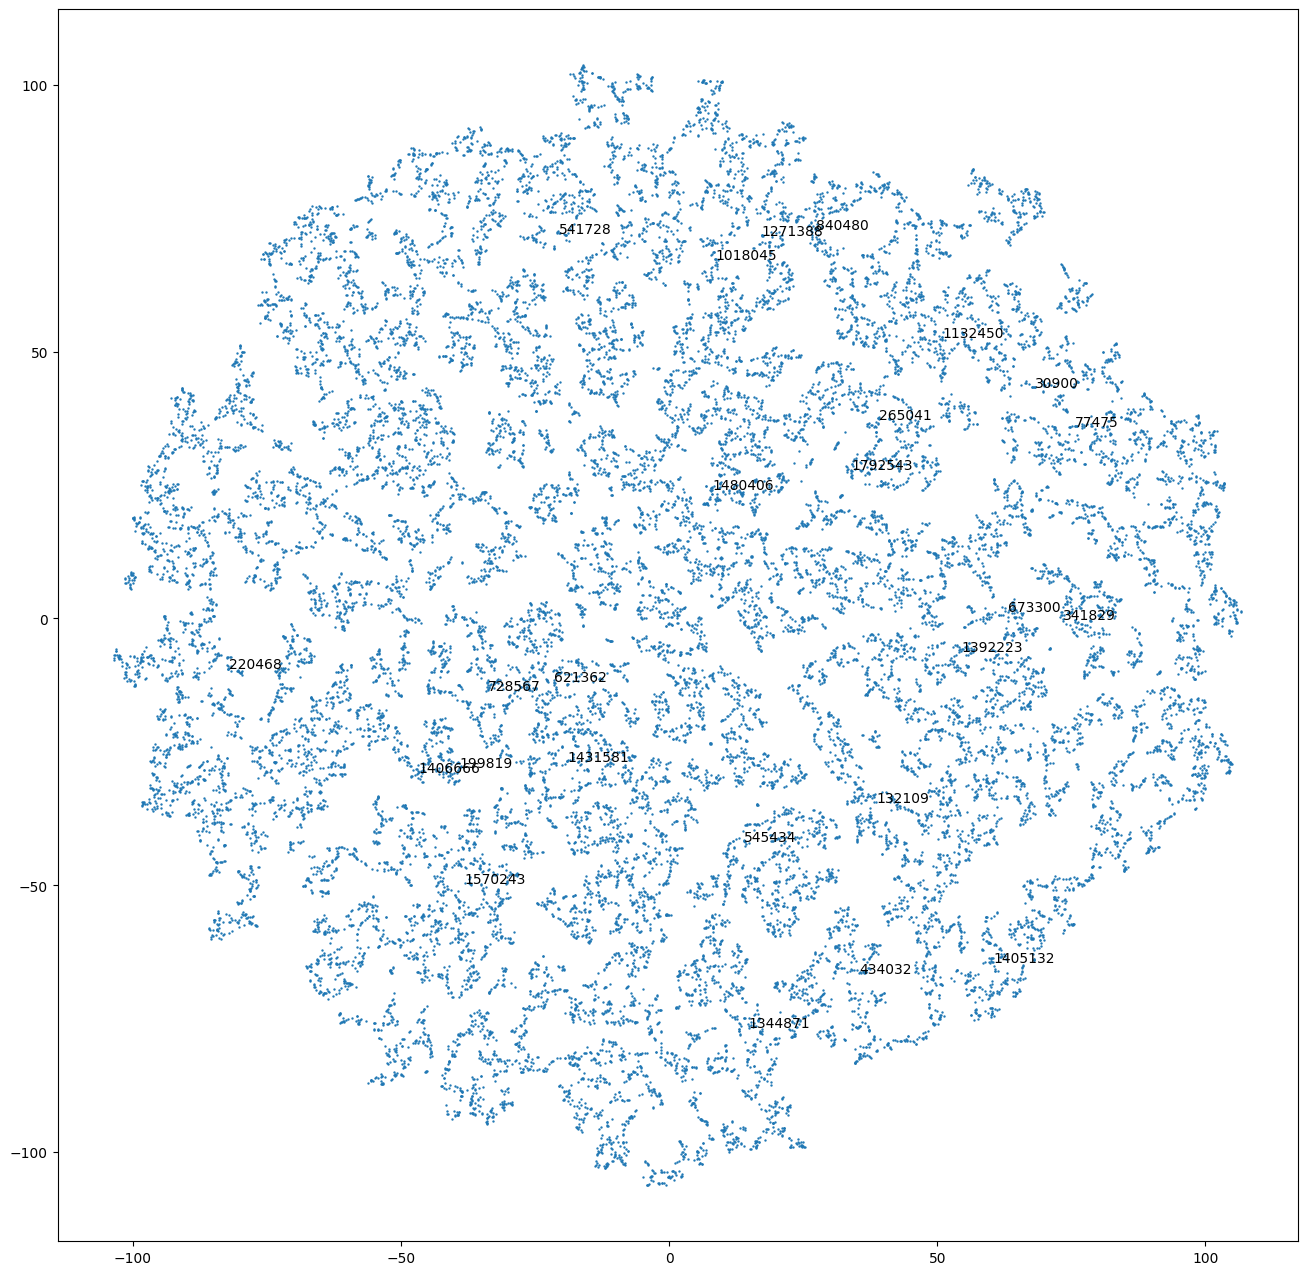

In [30]:
%%time
from sklearn.manifold import TSNE                   # final reduction
import numpy as np                                  # array handling


def reduce_dimensions(model):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    # extract the words & their vectors, as numpy arrays
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)  # fixed-width numpy strings

    # reduce using t-SNE
    tsne = TSNE(n_components=num_dimensions, random_state=0, n_jobs=-1)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels

print("Starting reduce...")
x_vals, y_vals, labels = reduce_dimensions(model)
print("...completed reduce")

def plot_with_matplotlib(x_vals, y_vals, labels):
    import matplotlib.pyplot as plt
    import random

    random.seed(0)

    plt.figure(figsize=(16, 16))
    plt.scatter(x_vals, y_vals, s=0.5)

    # Label randomly subsampled 25 data points
    indices = list(range(len(labels)))
    selected_indices = random.sample(indices, 25)
    for i in selected_indices:
        plt.annotate(labels[i], (x_vals[i], y_vals[i]))

plot_with_matplotlib(x_vals, y_vals, labels)

In [148]:
%%time

# Aggregate types
bool_carts = df['type']=='carts'
bool_clicks = df['type']=='clicks'
bool_orders = df['type']=='orders'

carts = df[bool_carts].groupby('session').apply(lambda x:list(x['aid'])).reset_index().rename(columns={0:'carts'})
clicks = df[bool_clicks].groupby('session').apply(lambda x:list(x['aid'])).reset_index().rename(columns={0:'clicks'})
orders = df[bool_orders].groupby('session').apply(lambda x:list(x['aid'])).reset_index().rename(columns={0:'orders'})

df_agg = (
    clicks
    .join(carts,on='session',rsuffix='_r').drop(['session_r'],axis=1)
    .join(orders,on='session',rsuffix='_r').drop(['session_r'],axis=1)
)
df_agg.apply(lambda df_:)

CPU times: total: 1.88 s
Wall time: 1.87 s


,session,clicks,carts,orders
0,0,"[1517085, 1563459, 1309446, 16246, 1781822, 11...","[1649869, 461689, 789245, 974651, 974651, 9746...","[305831, 461689, 1199474, 543308]"
1,1,"[1492293, 910862, 1491172, 424964, 1515526, 44...","[424964, 1492293, 910862, 1491172, 854637, 215...","[357461, 1343406, 1425967, 1018433, 54857]"
2,2,"[763743, 137492, 504789, 137492, 795863, 37834...",[161269],[298827]
3,3,"[1425967, 1343406, 1343406, 1425967, 1343406, ...","[1425967, 1343406, 1089061, 984459, 1660613, 7...","[987969, 1145803]"
4,4,"[613619, 298827, 383828, 255379, 1838173, 1453...","[1554752, 917213, 758750]",[832890]
5,5,"[1098089, 1354785, 342507, 1120175, 1808870, 1...",[1813405],"[887719, 1742191, 618376, 1689065, 1757034, 16..."
6,6,"[137164, 956148, 1310382, 705239, 1438169, 515...",[847707],"[571631, 588838, 275825, 326526, 1054943, 1664..."
7,7,"[87774, 1241611, 477883, 1209125, 1727444, 436...","[987969, 1145803, 1528062]",[791627]
8,8,"[1814223, 324620, 1320098, 324620]",[832890],"[1393473, 1143723]"
9,9,"[847707, 1078113, 502913, 502913, 1369253, 641...","[1757034, 1742191, 618376, 1689065, 887719, 92...","[1213426, 1006109, 165455, 719255, 383546, 228..."


In [112]:
df.loc[lambda df_:df_['type']=='carts']

,aid,type,session,dt
6,1649869,carts,0,2022-08-01 16:04:53.840
7,461689,carts,0,2022-08-01 16:04:58.050


In [17]:
%%time
"""
How long does it take to scan and parse the whole file in Python?
"""
# Open file in read-only mode
with jsonlines.open("../data/train.jsonl", "r") as reader:
    # Iterate over parsed JSON objects
    for i, obj in enumerate(reader):
        if i % 1_000_000==0:
            print(f"Object: {i:,d}")

Object: 0
Object: 1,000,000
Object: 2,000,000
Object: 3,000,000
Object: 4,000,000
Object: 5,000,000
Object: 6,000,000
Object: 7,000,000
Object: 8,000,000
Object: 9,000,000
Object: 10,000,000
Object: 11,000,000
Object: 12,000,000
CPU times: total: 4min 4s
Wall time: 4min 5s
